In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
import warnings
warnings.filterwarnings("ignore")

movies_path = './exp1_data/movies.dat'
users_path = './exp1_data/users.dat'
ratings_path = './exp1_data/ratings.dat'
movies_column = ['MovieID','Title','Genres']
users_column = ['UserID','Gender','Age','Occupation','Zip-code']
ratings_column = ['UserID','MovieID','Rating','Timestamp']

## 读取资料
def read_dat(filePath,column):
    f = open(filePath,encoding='unicode_escape')
    datlist = []
    for line in f:
        l = line.strip().split('::')
        datlist.append(l)
    return pd.DataFrame(datlist,columns=column)

In [4]:
df_movies = read_dat(movies_path,movies_column)
df_users = read_dat(users_path,users_column)
df_ratings = read_dat(ratings_path,ratings_column)
df_ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [5]:
## 把数据资料分成两部分：训练集90% 测试集10%
def splitData(df_data):
    mask = np.random.rand(len(df_data))<.9
    train_data = df_data[mask]
    test_data = df_data[~mask]
    return train_data,test_data
    
train_ratings,test_ratings = splitData(df_ratings)

In [6]:
train_ratings.shape,test_ratings.shape

((900593, 4), (99616, 4))

In [7]:
## 评价>3的用户-电影_DataFrame
def users_prefer_movies(ratings):
    ratings['prefer'] = ratings['Rating'] > '3'
    ratings['prefer'] = ratings['prefer'].astype(int)
    user_movie = pd.DataFrame(ratings,columns=['UserID','MovieID','prefer'])
    user_movie_prefer = user_movie[user_movie['prefer']==True]
    return user_movie_prefer

In [8]:
## 用户和电影的数量
## n表示用户数量;m表示电影数量 
n = len(df_users.UserID.unique())
m = np.max(np.array(df_movies.MovieID,dtype=np.int64))
n,m

(6040, 3952)

## Process 1:
用户对自己看过的电影打分1-5分，其中1分表示最不喜欢，5分表示最喜欢。假设分数大于3分的，表示用户喜欢这部电影，在二部图中构建一条从用户到该电影的连边。

考虑由m个用户n部电影构成的电影推荐系统。用户i对电影j打分超过3分，就在i和j之间连接一条边$a_{ji}=1$,否则$a_{ji}$=0。

In [9]:
users_prefer_movies(train_ratings)

,UserID,MovieID,prefer
0,1,1193,1
3,1,3408,1
4,1,2355,1
7,1,2804,1
8,1,594,1
...,...,...,...
1000202,6040,1089,1
1000205,6040,1094,1
1000206,6040,562,1
1000207,6040,1096,1


In [10]:
## 建立用户电影矩阵A
def create_matA(ratings):
    mat_A = np.zeros((n,m))
    dis_mat_A = np.zeros((n,m))
    for _,triple in ratings.iterrows():
        if int(triple[2]) > 3:mat_A[int(triple[0])-1,int(triple[1])-1] = 1
        else:dis_mat_A[int(triple[0])-1,int(triple[1])-1] = 1
    return dis_mat_A,mat_A

In [11]:
dis_train_a,train_a = create_matA(train_ratings)
dis_test_a,test_a = create_matA(test_ratings) 

In [12]:
train_a,train_a.shape,test_a,test_a.shape 

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (6040, 3952),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (6040, 3952))

In [13]:
train_a.shape,test_a.shape

((6040, 3952), (6040, 3952))

## Process 2:计算资源配额矩阵；
计算资源配额矩阵W中的元素wij表示产品j愿意分配给产品i的资源配额。假设一个用户选择过的商品j都有向该用户推荐其他产品i的能力。
$$
w_{ij} = \frac{1}{k_j} \sum^n_{l=1}\frac{a_{li}a_{lj}}{k_l}
$$
kj表示产品j的度（被多少用户评价过），kl表示用户l的度（用户选择过多少产品）。

In [14]:
def k_counts_mat(ratings):
    mat = np.zeros((n,m))
    for _,triple in ratings.iterrows():
        mat[int(triple[0])-1,int(triple[1])-1] = 1
    return mat

In [15]:
k_counts = k_counts_mat(df_ratings)

In [16]:
user_count = k_counts.sum(axis=1)
movie_count = k_counts.sum(axis=0)

In [17]:
m,n,user_count.shape,movie_count.shape,user_count,movie_count

(3952,
 6040,
 (6040,),
 (3952,),
 array([ 53., 129.,  51., ...,  20., 123., 341.]),
 array([2077.,  701.,  478., ...,   54.,   40.,  388.]))

In [18]:
train_a.shape,movie_count.shape,user_count.shape

((6040, 3952), (3952,), (6040,))

In [19]:
## 建立矩阵W
def create_matW(matA,user_cnt,movies_cnt):
    temp = (matA / user_cnt.reshape([-1,1])) / movies_cnt
    return np.dot(matA.T,temp)

In [20]:
mat_W = create_matW(train_a,user_count,movie_count)

In [21]:
mat_W[np.isnan(mat_W)] = 0
mat_W,mat_W.shape

(array([[5.72507183e-03, 7.63753768e-04, 5.19492771e-04, ...,
         5.89987503e-04, 4.08607679e-04, 6.87558711e-04],
        [2.57771493e-04, 1.90644932e-03, 8.37462035e-05, ...,
         7.85648156e-05, 0.00000000e+00, 1.09970491e-04],
        [1.19555871e-04, 5.71051145e-05, 1.94402109e-03, ...,
         4.62494121e-05, 0.00000000e+00, 4.70142614e-05],
        ...,
        [1.53391070e-05, 6.05206853e-06, 5.22482899e-06, ...,
         3.00389134e-03, 3.41718381e-04, 1.28253530e-04],
        [7.86918977e-06, 0.00000000e+00, 0.00000000e+00, ...,
         2.53124727e-04, 5.81743503e-03, 2.75530431e-04],
        [1.28441396e-04, 6.08681175e-05, 3.81622038e-05, ...,
         9.21525364e-04, 2.67264518e-03, 5.55578219e-03]]),
 (3952, 3952))

## pro 3:
对给定用户，按照其喜欢程度，对电影进行排名，进行电影推荐；
目标用户的资源分配矢量f。初始时，将他选择过的电影对应项资源设置为1，其他为0，得到初始n维0/1向量。则最终的资源分配矢量:
$$
f' = Wf
$$
 
将用户所有没看过的电影按照f'中对应项的得分进行排序，推荐排序靠前的电影给该用户。


In [22]:
train_a.shape,mat_W.shape

((6040, 3952), (3952, 3952))

In [23]:
def create_matF(matW,matA):
    temp = np.dot(matW,matA.T).T
    return temp 

In [24]:
mat_F = create_matF(mat_W,train_a)

In [25]:
mat_F[np.isnan(mat_F)] = 0
mat_F,mat_F.shape

(array([[5.84903579e-02, 7.14387305e-03, 3.49469111e-03, ...,
         6.43977636e-04, 7.12466277e-04, 6.59714625e-03],
        [7.30389533e-02, 9.61691447e-03, 4.85278858e-03, ...,
         1.16618052e-03, 9.49985482e-04, 1.12091432e-02],
        [3.72860052e-02, 6.55720936e-03, 3.01855547e-03, ...,
         6.05822921e-04, 1.83840917e-04, 3.85142186e-03],
        ...,
        [1.61457049e-02, 1.70856183e-03, 9.05138645e-04, ...,
         2.36339333e-04, 1.17648722e-04, 1.66918186e-03],
        [9.23183200e-02, 1.21427064e-02, 5.13987021e-03, ...,
         1.59330360e-03, 1.78492813e-03, 1.19082376e-02],
        [1.87385372e-01, 2.05502359e-02, 7.81523065e-03, ...,
         4.11771282e-03, 4.30018154e-03, 3.48720082e-02]]),
 (6040, 3952))

In [26]:
## 将用户所有没看过的电影按照f'中对应项的得分进行排序，推荐排序靠前的电影给该用户。
sort_matF = m - np.argsort(mat_F,axis=1)
sort_matF

array([[ 138,  301,  926, ..., 1925, 3693, 1095],
       [ 632, 3293, 2145, ..., 2757, 1925, 1095],
       [2374, 3131, 3128, ..., 2755, 2757, 3693],
       ...,
       [ 726, 1504,  266, ..., 2757, 2743, 1095],
       [2645, 2130, 2133, ..., 2757, 1095, 3693],
       [3349, 2553,   63, ..., 3095, 3345, 1095]], dtype=int64)

## pro 4:
4、	算法预测准确性预测；
将二部图中的边随机分为两部分，期中90%归为训练集，10%归为测试集。
对给定用户i，假设其有Li个产品是未选择的，如果在测试集中用户i选择的电影j，而电影j依据向量 被排在第Rij位，则计算其相对位置：
$$
r_{ij} = \frac{R_{ij}}{L_i}
$$
越精确的算法，给出的rij越小。对所有用户的rij求平均值 来量化评价算法的精确度。


In [27]:
def create_matr(sortF,matA):
    ## 对给定用户i，假设其有Li个产品是未选择的
    matL = m - user_count     #所有电影数 - 该用户已选择电影数
    R = np.zeros((n,m))
    R = sortF * matA
    return np.average(R / matL.reshape([-1,1]))

In [28]:
mat_r = create_matr(sort_matF,test_a)

In [29]:
avg_r = np.average(mat_r)
avg_r

0.001321749693663017

5、	画出ROC曲线来度量预测方法的准确性。
选取不同的算法阈值，计算相应的真阳性率（TP）以及假阳性率（FP），画出ROC曲线。


In [61]:
def roc_pic(f_mat,user_count,mat_rat,mat_dislike,num):
    threshold_rate = np.linspace(0,1,num)

    sort_result = np.argsort(-f_mat, axis=1)
    th_fprs = np.zeros(num)
    th_tprs = np.zeros(num)
    for i,threshold in enumerate(threshold_rate):
        recommond_num = int(mat_rat.shape[1] * threshold)
        fprs = np.zeros(user_count.shape[0])
        tprs = np.zeros(user_count.shape[0])
        for user in range(user_count.shape[0]):
            recommond_movie = sort_result[user,0:recommond_num]
            user_like = np.where(mat_rat[user,:] == 1)[0]
            user_dislike = np.where(mat_dislike[user,:] == 1)[0]
            like = np.intersect1d(recommond_movie, user_like)
            dis_like = np.intersect1d(recommond_movie, user_dislike)
            if len(user_dislike) ==0:fprs[user] = 0
            else:fprs[user] = len(dis_like) / len(user_dislike)
            if len(user_like) ==0:tprs[user] = 0
            else:tprs[user] = len(like) / len(user_like)
        th_fprs[i] = fprs.mean()
        th_tprs[i] = tprs.mean()
    roc_auc = auc(th_fprs,th_tprs)
    lw = 5
    plt.rc('font', family='SimHei', size=13)
    plt.figure(figsize=(10, 10))
    plt.plot(th_fprs, th_tprs,lw=lw, label='ROC曲线(AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC曲线')
    plt.legend(loc="lower right")
    plt.show()


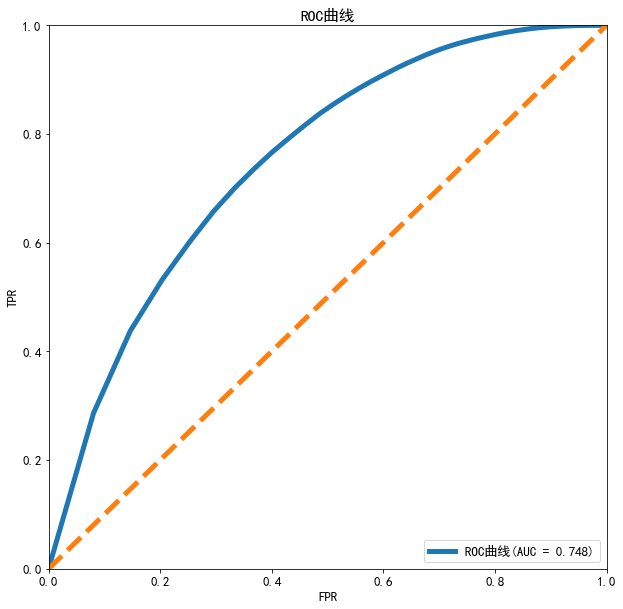

In [63]:
roc_pic(mat_F, user_count, train_a, dis_train_a,100)